Кількість дублікатів: 0
Пропущені значення:
id                             0
is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
reamining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64


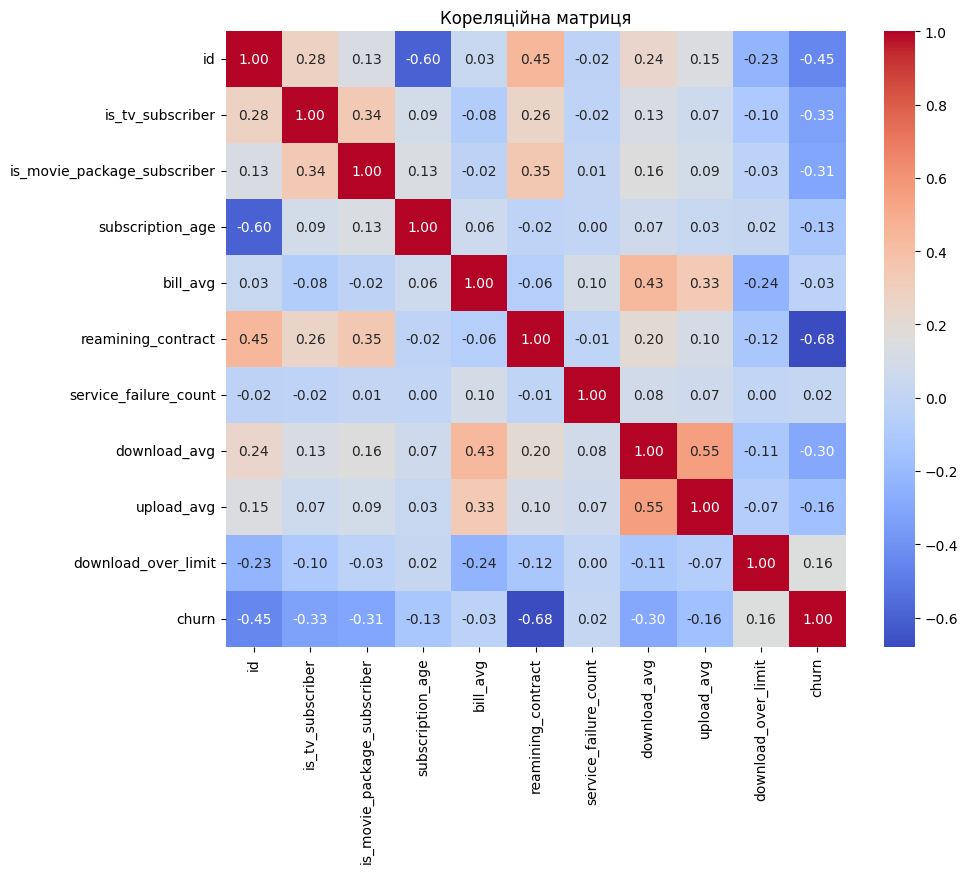

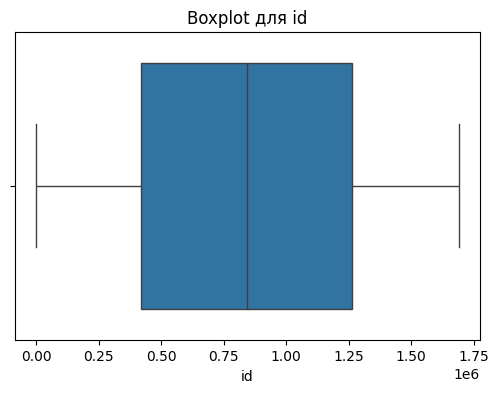

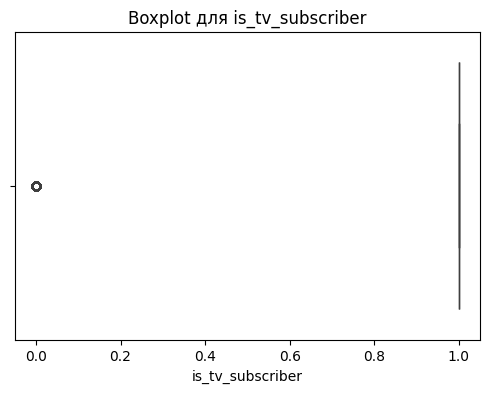

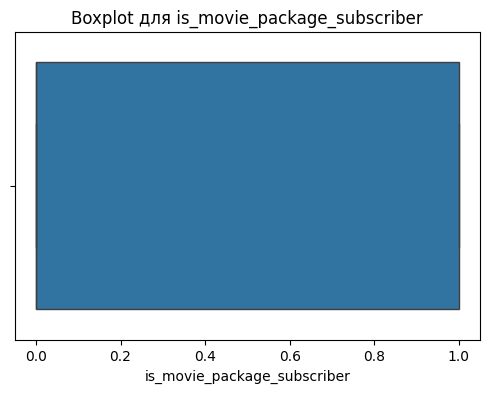

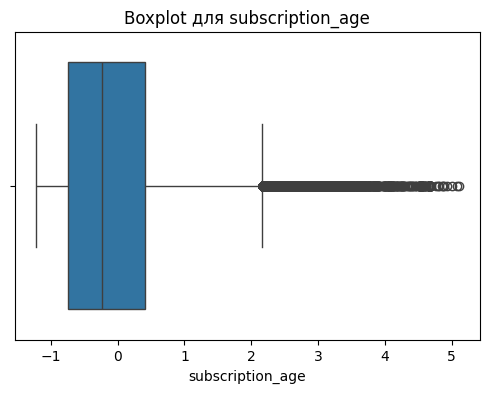

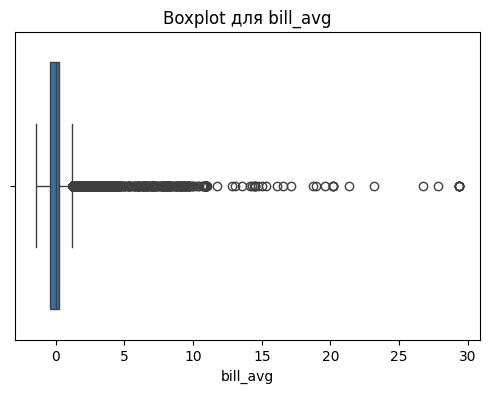

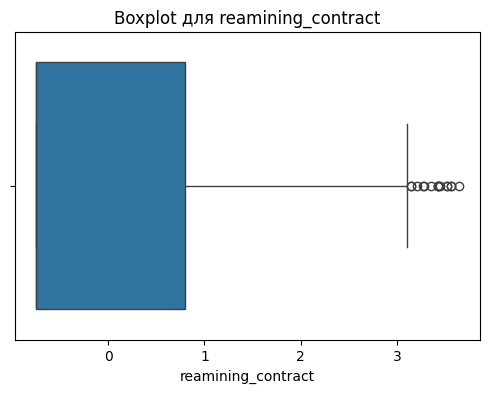

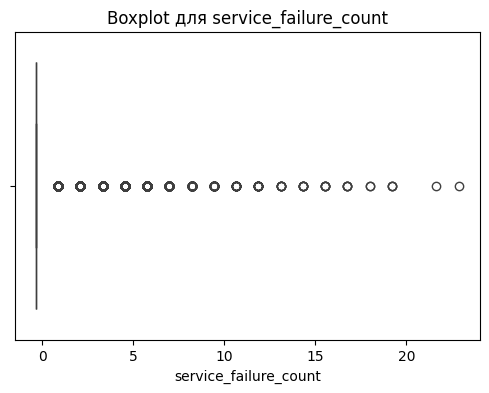

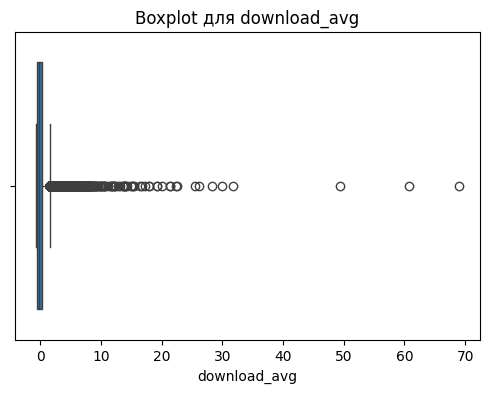

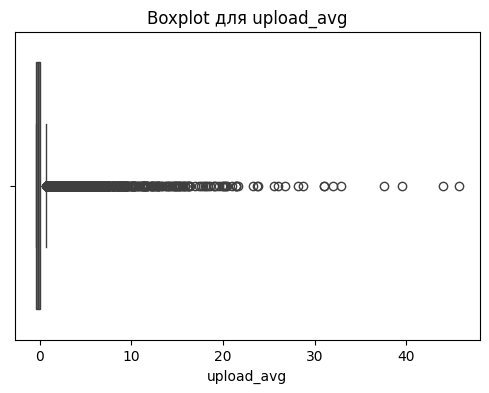

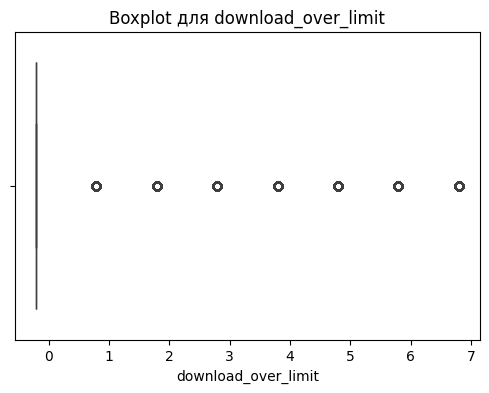

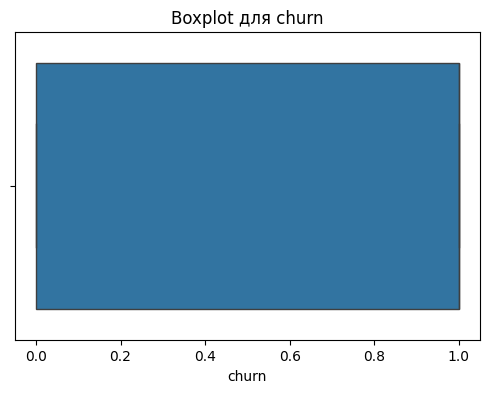

Найкращі параметри: {'model__border_count': 32, 'model__depth': 5, 'model__iterations': 100, 'model__l2_leaf_reg': 3, 'model__learning_rate': 0.1}
Accuracy: 0.9410588542119447
Recall: 0.9383744694230467
Precision: 0.9542765787370104
F1-score: 0.9462587190868738


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.pipeline import Pipeline

# Завантаження даних
data = pd.read_csv("data_normalized.csv")

# 1. Перевірка на дублікати
print("Кількість дублікатів:", data.duplicated().sum())
data = data.drop_duplicates()  # Видалення дублікатів

# 2. Перевірка на пропущені значення
print("Пропущені значення:")
print(data.isnull().sum())

# Заповнення пропущених значень нулями
data = data.fillna(0)

# 3. Аналіз кореляції
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Кореляційна матриця")
plt.show()

# 4. Виявлення викидів
numerical_cols = data.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot для {col}")
    plt.show()

# Виправлення викидів
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

# 5. Використання меншого набору даних для тестування
data = data.sample(frac=0.8, random_state=42)

# 6. Підготовка даних для моделі
data = data.drop(columns=["id"])  # Видалення непотрібного стовпця
data = pd.get_dummies(data, drop_first=True)  # Кодування категоріальних змінних

# Розділення на X та y
X = data.drop(columns=["churn"])
y = data["churn"]

# Розділення на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Побудова моделі з використанням CatBoost
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Нормалізація даних
    ("model", CatBoostClassifier(random_state=42, verbose=False))
])

# 8. Зменшений набір гіперпараметрів для GridSearchCV
param_grid = {
    "model__iterations": [100],
    "model__depth": [3, 5],
    "model__learning_rate": [0.1],
    "model__l2_leaf_reg": [3],
    "model__border_count": [32]
}

# 9. Навчання моделі з крос-валідацією (cv=3)
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 10. Найкращі параметри
print("Найкращі параметри:", grid_search.best_params_)

# 11. Оцінка моделі на тестовому наборі
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))